In [1]:
DEBUG=False
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(DEBUG)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


In [2]:
from disentangle.configs.biosr_sparsely_supervised_config import get_config
from disentangle.data_loader.multi_channel_determ_tiff_dloader import MultiChDeterministicTiffDloader, GridAlignement
from typing import Tuple, Union
import numpy as np
import torch

class SupClassificationDset(MultiChDeterministicTiffDloader):
    def __getitem__(self, index: Union[int, Tuple[int, int]]) -> Tuple[np.ndarray, np.ndarray]:
        assert self._validtarget_random_fraction_final is None
        sup = False
        if np.random.rand() < self._validtarget_rand_fract:
            index = self._train_index_switcher.get_valid_target_index()
            sup = True
        else:
            index = self._train_index_switcher.get_invalid_target_index()

        img_tuples = self._get_img(index)
        if self._empty_patch_replacement_enabled:
            if np.random.rand() < self._empty_patch_replacement_probab:
                img_tuples = self.replace_with_empty_patch(img_tuples)

        if self._enable_rotation:
            # passing just the 2D input. 3rd dimension messes up things.
            assert len(img_tuples) == 2
            rot_dic = self._rotation_transform(image=img_tuples[0][0], mask=img_tuples[1][0])
            img1 = rot_dic['image'][None]
            img2 = rot_dic['mask'][None]
            img_tuples = (img1, img2)

        inp, alpha = self._compute_input(img_tuples)

        if alpha != 0.5:
            assert len(img_tuples) == 2
            img_tuples = [img_tuples[0] * alpha / 0.5, img_tuples[1] * (1 - alpha) / 0.5]

        return inp, sup

config = get_config()
dset = SupClassificationDset(
    config.data,
    #    '/group/jug/ashesh/data/microscopy/OptiMEM100x014.tif',
    '/group/jug/ashesh/data/BioSR/',
    DataSplitType.Train,
    val_fraction=config.training.val_fraction,
    test_fraction=config.training.test_fraction,
    normalized_input=config.data.normalized_input,
    enable_rotation_aug=config.data.normalized_input,
    enable_random_cropping=config.data.deterministic_grid is False,
    use_one_mu_std=config.data.use_one_mu_std,
    allow_generation=False,
    max_val=None,
    grid_alignment=GridAlignement.LeftTop,
    overlapping_padding_kwargs=None)

mean, std = dset.compute_mean_std()
dset.set_mean_std(mean, std)


Loading from /group/jug/ashesh/data/BioSR/ Channel1: /group/jug/ashesh/data/BioSR/Microtubules/GT_all.mrc,/group/jug/ashesh/data/BioSR/ER/GT_all.mrc, Mode:Train
[IndexSwitcher] Target Indices: [0,0]. Index=0 has shape [:673,:673].  Available data: 45
[SupClassificationDset] Sz:128 Train:1 N:45 NumPatchPerN:49 NormInp:True SingleNorm:True Rot:True RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0


In [98]:
init_ch_count = 64
num_hierarchies = 3
num_initial_downsamples = 2


In [99]:
from disentangle.nets.pix2pix_discriminator import Discriminator
model = Discriminator(in_channels=1, init_ch_count=init_ch_count, num_hierarchies=num_hierarchies, 
                      num_initial_downsamples=num_initial_downsamples)
model = model.cuda()
model


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ZeroPad2d((1, 0, 1, 0))
    (9): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [100]:
import torch.nn.functional as F

class History:
    def __init__(self):
        self.losses = []
        self.accs = []

    def plot(self):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(self.losses, label='train')
        ax[0].set_title('Loss')
        ax[0].legend()
        ax[1].plot(self.accs, label='train')
        ax[1].set_title('Accuracy')
        ax[1].legend()
        plt.show()
    
def train_epoch(model, data_loader, criterion, optimizer):
    """
    This function trains the model for one epoch.
    """
    # Set model to training mode
    model.train()
    # Initialize running values
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for inputs, labels in data_loader:
        # Move inputs and labels to device
        inputs = inputs.cuda()
        labels = labels.cuda().float()
        # labels = F.one_hot(labels, num_classes=2).float()
        
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        outputs = torch.mean(outputs, dim=(1,2, 3))
        # Compute loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Compute running values
        preds = torch.round(torch.sigmoid(outputs))
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    # Return epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.float().item() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

def train(model, dset, num_epochs=10, batch_size=64):
    """
    Here, we create a data loader, optimizer, and loss function.
    Then, we train the model for 10 epochs. We log the loss and accuracy to stdout.
    After each epoch, we store the average loss and accuracy in the history object.
    """
    # Create data loader
    data_loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=True)
    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.5, 0.999))
    # Create loss function
    criterion = torch.nn.BCEWithLogitsLoss()
    # Create history object
    history = History()
    # tqdm bar with loss and accuracy
    bar = tqdm(range(num_epochs), desc=f'Loss: {0:.4f}, Accuracy: {0:.4f}')
    # Train model
    for epoch in bar:
        loss, accuracy = train_epoch(model, data_loader, criterion, optimizer)
        history.losses.append(loss)
        history.accs.append(accuracy)
        bar.set_description(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
        # print(f"Epoch {epoch}: loss={loss:.2f}, accuracy={accuracy:.3f}")
    return history
    

In [101]:
history = train(model, dset, num_epochs=100,batch_size=32)

Loss: 0.1346, Accuracy: 0.9510: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


In [102]:
with torch.no_grad():
    inp, flag = dset[0]
    inp = torch.Tensor(inp[None]).cuda()
    out = model(inp)
    out = torch.sigmoid(out)
    print(flag, out.mean().item())

False 0.23967550694942474


In [103]:
dloader = torch.utils.data.DataLoader(dset, batch_size=128, shuffle=True)
pred_arr = []
gt_arr = []
with torch.no_grad():
    for inp, flag in tqdm(dloader):
        inp = inp.cuda()
        out = model(inp)
        out = torch.sigmoid(out)
        pred_arr.append(out.mean(dim=(1,2,3)).cpu().numpy())
        gt_arr.append(flag.numpy())

pred_arr = np.concatenate(pred_arr)
gt_arr = np.concatenate(gt_arr)

100%|██████████| 18/18 [00:00<00:00, 38.57it/s]


In [104]:
print('Average confidence for positive samples', pred_arr[gt_arr].mean())
print('Average confidence for negative samples', pred_arr[~gt_arr].mean())

Average confidence for positive samples 0.6859884
Average confidence for negative samples 0.34651574


<Axes: >

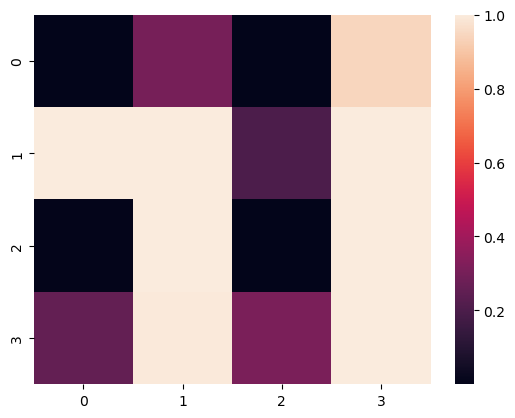

In [105]:
import seaborn as sns
sns.heatmap(out[0,0].cpu().numpy())

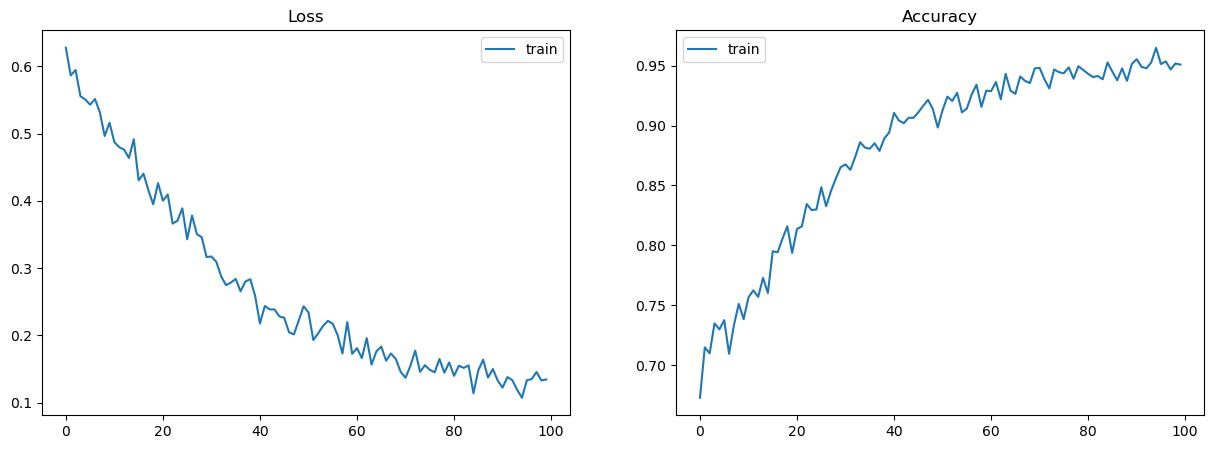

In [106]:
history.plot()

In [13]:
history.accs[-10:]

[0.7854875283446712,
 0.7927437641723356,
 0.7845804988662132,
 0.7786848072562358,
 0.7841269841269841,
 0.7768707482993197,
 0.7895691609977324,
 0.8054421768707483,
 0.7528344671201814,
 0.7950113378684808]